**End-to-End Customer Intelligence & Analytics Platform by Spandana Damannagari**

This notebook builds a complete customer analytics workflow:

1) Generates multi-source customer data (customers,transactions, interactions, events)

2) Runs data quality checks + cleaning

3) Integrates data into a SQLite database

4) Builds customer_features (RFM + engagement + support metrics)

5) Creates segments (RFM + KMeans clustering)

6) Builds cohort retention

7) Exports clean CSVs for Power BI

In [21]:
# Setup: imports, configs, output folder
import os, sqlite3, random, warnings
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

OUT_DIR = "/content/customer_intelligence_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

print("Output folder:", OUT_DIR)

Output folder: /content/customer_intelligence_outputs


**Step 1: Generate multi-source synthetic data**
We simulate real-world sources:

1) customers: demographics + signup details

2) transactions: orders, amounts, promo usage, returns

3) interactions: support tickets/chats/calls

4) events: web/app usage behavior

We also intentionally add dirty data:

1) duplicate customers

2) missing regions

3) inconsistent category casing

In [22]:
def random_date(start: datetime, end: datetime, n: int):
    """Generate n random datetimes between start and end."""
    delta = (end - start).total_seconds()
    return [start + timedelta(seconds=random.random() * delta) for _ in range(n)]

def make_synthetic_data(
    n_customers=3000,
    start_date="2024-01-01",
    end_date="2025-12-31",
):
    start = datetime.fromisoformat(start_date)
    end = datetime.fromisoformat(end_date)

    # -------------------
    # Customers
    # -------------------
    customer_ids = [f"C{str(i).zfill(6)}" for i in range(1, n_customers + 1)]
    signup_dates = random_date(start, end - timedelta(days=30), n_customers)

    regions = ["Northeast", "Midwest", "South", "West"]
    acquisition_channels = ["Organic", "Paid Search", "Social", "Referral", "Email"]
    devices = ["Web", "Mobile"]

    customers = pd.DataFrame({
        "customer_id": customer_ids,
        "signup_date": pd.to_datetime(signup_dates),
        "region": np.random.choice(regions, size=n_customers, p=[0.25, 0.20, 0.30, 0.25]),
        "acquisition_channel": np.random.choice(acquisition_channels, size=n_customers, p=[0.30, 0.25, 0.20, 0.15, 0.10]),
        "primary_device": np.random.choice(devices, size=n_customers, p=[0.45, 0.55]),
        "age": np.random.randint(18, 70, size=n_customers),
    })

    # -------------------
    # Transactions
    # -------------------
    base_lambda = 3.0
    channel_multiplier = customers["acquisition_channel"].map({
        "Organic": 1.1, "Paid Search": 1.0, "Social": 0.9, "Referral": 1.2, "Email": 1.15
    }).values
    device_multiplier = customers["primary_device"].map({"Web": 1.0, "Mobile": 1.05}).values

    expected_orders = (base_lambda * channel_multiplier * device_multiplier).clip(0.5, 10)
    n_orders_each = np.random.poisson(lam=expected_orders).clip(0, 40)

    order_rows = []
    product_categories = ["Electronics", "Apparel", "Home", "Beauty", "Sports"]
    payment_methods = ["Card", "PayPal", "ApplePay", "GooglePay"]
    promo_used_prob = {"Electronics": 0.25, "Apparel": 0.45, "Home": 0.35, "Beauty": 0.40, "Sports": 0.30}

    order_id_counter = 1
    for cid, signup, k in zip(customers["customer_id"], customers["signup_date"], n_orders_each):
        if k == 0:
            continue
        tx_dates = random_date(max(start, signup.to_pydatetime()), end, int(k))
        for dt in tx_dates:
            cat = np.random.choice(product_categories, p=[0.22, 0.26, 0.20, 0.17, 0.15])
            amount_mu = {"Electronics": 220, "Apparel": 80, "Home": 130, "Beauty": 60, "Sports": 95}[cat]
            amount_sigma = {"Electronics": 90, "Apparel": 35, "Home": 55, "Beauty": 25, "Sports": 40}[cat]
            amount = max(5, np.random.normal(amount_mu, amount_sigma))

            promo_used = np.random.rand() < promo_used_prob[cat]
            discount = np.random.uniform(0.05, 0.30) * amount if promo_used else 0.0
            net_amount = max(0, amount - discount)

            return_prob = {"Electronics": 0.05, "Apparel": 0.12, "Home": 0.08, "Beauty": 0.06, "Sports": 0.07}[cat]
            returned = np.random.rand() < return_prob

            order_rows.append({
                "order_id": f"O{order_id_counter:08d}",
                "customer_id": cid,
                "transaction_time": pd.to_datetime(dt),
                "product_category": cat,
                "gross_amount": round(float(amount), 2),
                "discount_amount": round(float(discount), 2),
                "net_amount": round(float(net_amount), 2),
                "payment_method": np.random.choice(payment_methods),
                "promo_used": int(promo_used),
                "returned": int(returned),
            })
            order_id_counter += 1

    transactions = pd.DataFrame(order_rows)

    # -------------------
    # Interactions (Support)
    # -------------------
    tx_per_cust = transactions.groupby("customer_id").agg(
        orders=("order_id", "count"),
        returns=("returned", "sum")
    ).reset_index()

    cust = customers.merge(tx_per_cust, on="customer_id", how="left").fillna({"orders": 0, "returns": 0})

    interact_lambda = (0.15 * cust["orders"] + 0.6 * cust["returns"] + 0.2).clip(0.1, 15)
    n_interactions_each = np.random.poisson(interact_lambda).clip(0, 60)

    interaction_types = ["Ticket", "Chat", "Call"]
    issue_types = ["Billing", "Shipping", "Product Issue", "Returns", "Account", "Other"]
    priorities = ["Low", "Medium", "High"]

    inter_rows = []
    inter_id_counter = 1
    for cid, signup, k in zip(cust["customer_id"], cust["signup_date"], n_interactions_each):
        if k == 0:
            continue
        it_dates = random_date(max(start, signup.to_pydatetime()), end, int(k))
        for dt in it_dates:
            issue = np.random.choice(issue_types, p=[0.12, 0.20, 0.22, 0.18, 0.18, 0.10])
            pr = np.random.choice(priorities, p=[0.50, 0.35, 0.15])
            base = {"Low": 12, "Medium": 24, "High": 48}[pr]
            complexity = {"Billing": 1.1, "Shipping": 1.0, "Product Issue": 1.4, "Returns": 1.2, "Account": 1.1, "Other": 0.9}[issue]
            resolution_hours = max(1, np.random.normal(base * complexity, 8))

            inter_rows.append({
                "interaction_id": f"I{inter_id_counter:08d}",
                "customer_id": cid,
                "interaction_time": pd.to_datetime(dt),
                "interaction_type": np.random.choice(interaction_types, p=[0.45, 0.40, 0.15]),
                "issue_type": issue,
                "priority": pr,
                "resolution_hours": round(float(resolution_hours), 1),
                "resolved": 1,
            })
            inter_id_counter += 1

    interactions = pd.DataFrame(inter_rows)

    # -------------------
    # Events (Web/App Usage)
    # -------------------
    expected_sessions = (2.5 * cust["orders"] + 3.0).clip(5, 200)
    n_sessions_each = np.random.poisson(expected_sessions).clip(1, 300)

    event_rows = []
    session_id_counter = 1
    features = ["Search", "Browse", "ProductView", "AddToCart", "Checkout", "SupportCenter"]
    for cid, signup, k in zip(cust["customer_id"], cust["signup_date"], n_sessions_each):
        sess_dates = random_date(max(start, signup.to_pydatetime()), end, int(k))
        for sd in sess_dates:
            m = np.random.randint(1, 12)
            feat_probs = np.array([0.22, 0.22, 0.22, 0.16, 0.10, 0.08])
            feat_probs = feat_probs + np.random.normal(0, 0.01, size=len(feat_probs))
            feat_probs = np.clip(feat_probs, 0.01, None)
            feat_probs = feat_probs / feat_probs.sum()

            for _ in range(m):
                event_rows.append({
                    "event_id": f"E{len(event_rows)+1:010d}",
                    "customer_id": cid,
                    "session_id": f"S{session_id_counter:09d}",
                    "event_time": pd.to_datetime(sd) + timedelta(minutes=int(np.random.randint(0, 45))),
                    "event_type": np.random.choice(features, p=feat_probs),
                    "device": np.random.choice(["Web", "Mobile"], p=[0.45, 0.55]),
                })
            session_id_counter += 1

    events = pd.DataFrame(event_rows)

    # -------------------
    # Add small "dirty data" issues
    # -------------------
    customers_dirty = pd.concat([customers, customers.sample(10, random_state=SEED)], ignore_index=True)
    idx = np.random.choice(customers_dirty.index, size=15, replace=False)
    customers_dirty.loc[idx, "region"] = None

    transactions_dirty = transactions.copy()
    if len(transactions_dirty) > 0:
        bad_idx = np.random.choice(transactions_dirty.index, size=min(30, len(transactions_dirty)), replace=False)
        transactions_dirty.loc[bad_idx, "product_category"] = transactions_dirty.loc[bad_idx, "product_category"].str.lower()

    return customers_dirty, transactions_dirty, interactions, events

In [23]:
customers_raw, transactions_raw, interactions_raw, events_raw = make_synthetic_data(
    n_customers=3000,
    start_date="2024-01-01",
    end_date="2025-12-31",
)

print("customers_raw:", customers_raw.shape)
print("transactions_raw:", transactions_raw.shape)
print("interactions_raw:", interactions_raw.shape)
print("events_raw:", events_raw.shape)

customers_raw.head()

customers_raw: (3010, 6)
transactions_raw: (9660, 10)
interactions_raw: (2480, 8)
events_raw: (200422, 6)


,customer_id,signup_date,region,acquisition_channel,primary_device,age
0,C000001,2025-03-23 14:22:12.770733,Midwest,Social,Mobile,54
1,C000002,2024-01-18 12:10:50.475867,West,Referral,Web,67
2,C000003,2024-07-11 12:29:33.174964,South,Organic,Mobile,32
3,C000004,2024-06-05 05:56:25.443241,South,Social,Mobile,29
4,C000005,2025-05-30 12:42:59.032639,Northeast,Social,Web,66


**Step 2: Data Quality Report**

We check:

1) row counts

2) missing cells

3) duplicate rows

In [24]:
def dq_report(df, name):
    return {
        "table": name,
        "rows": len(df),
        "cols": df.shape[1],
        "null_cells": int(df.isna().sum().sum()),
        "duplicate_rows": int(df.duplicated().sum()),
    }

dq = pd.DataFrame([
    dq_report(customers_raw, "customers_raw"),
    dq_report(transactions_raw, "transactions_raw"),
    dq_report(interactions_raw, "interactions_raw"),
    dq_report(events_raw, "events_raw"),
])

dq

,table,rows,cols,null_cells,duplicate_rows
0,customers_raw,3010,6,15,10
1,transactions_raw,9660,10,0,0
2,interactions_raw,2480,8,0,0
3,events_raw,200422,6,0,0


**Step 3: Clean and Standardize Data**

1) Deduplicate customers

2) Fill missing regions

3) Standardize product categories

4) Ensure amounts are valid and non-negative

5) Enforce datetime types

In [25]:
# Customers
customers_clean = customers_raw.sort_values("signup_date").drop_duplicates("customer_id", keep="first").copy()
# Fill missing region with mode
mode_region = customers_clean["region"].mode(dropna=True)[0]
customers_clean["region"] = customers_clean["region"].fillna(mode_region)
customers_clean["signup_date"] = pd.to_datetime(customers_clean["signup_date"])
customers_clean["age"] = customers_clean["age"].astype(int)
# Transactions
transactions_clean = transactions_raw.copy()
transactions_clean["transaction_time"] = pd.to_datetime(transactions_clean["transaction_time"])
transactions_clean["product_category"] = transactions_clean["product_category"].astype(str).str.strip().str.title()
for col in ["gross_amount", "discount_amount", "net_amount"]:
    transactions_clean[col] = pd.to_numeric(transactions_clean[col], errors="coerce").fillna(0).clip(lower=0)
transactions_clean["net_amount"] = np.minimum(transactions_clean["net_amount"], transactions_clean["gross_amount"])
# Interactions
interactions_clean = interactions_raw.copy()
interactions_clean["interaction_time"] = pd.to_datetime(interactions_clean["interaction_time"])
interactions_clean["resolution_hours"] = pd.to_numeric(interactions_clean["resolution_hours"], errors="coerce").fillna(0).clip(lower=0)
# Events
events_clean = events_raw.copy()
events_clean["event_time"] = pd.to_datetime(events_clean["event_time"])
print("customers_clean:", customers_clean.shape)
print("transactions_clean:", transactions_clean.shape)
print("interactions_clean:", interactions_clean.shape)
print("events_clean:", events_clean.shape)

customers_clean: (3000, 6)
transactions_clean: (9660, 10)
interactions_clean: (2480, 8)
events_clean: (200422, 6)


**Step 4: Load into SQLite (Integration Layer)**

This simulates a real pipeline where data is stored in a database after cleaning.

In [26]:
DB_PATH = os.path.join(OUT_DIR, "customer_intelligence.db")
if os.path.exists(DB_PATH):
    os.remove(DB_PATH)

conn = sqlite3.connect(DB_PATH)

customers_clean.to_sql("raw_customers", conn, index=False)
transactions_clean.to_sql("raw_transactions", conn, index=False)
interactions_clean.to_sql("raw_interactions", conn, index=False)
events_clean.to_sql("raw_events", conn, index=False)

print("Saved SQLite DB:", DB_PATH)

Saved SQLite DB: /content/customer_intelligence_outputs/customer_intelligence.db


**Step 5: Build Curated Tables + Customer Feature Store**

We create:

1) dim_customer

2) fact_transactions

3) fact_interactions

4) fact_events

5) customer_features (1 row per customer)

Includes:

1) RFM (Recency, Frequency, Monetary)

2) Engagement (sessions/events)

3) Support metrics (tickets, resolution)

4) Cohorts

In [27]:
dim_customer = customers_clean.copy()

fact_transactions = transactions_clean.merge(
    dim_customer[["customer_id", "signup_date", "region", "acquisition_channel", "primary_device"]],
    on="customer_id",
    how="left"
)

fact_interactions = interactions_clean.merge(
    dim_customer[["customer_id", "signup_date", "region", "acquisition_channel", "primary_device"]],
    on="customer_id",
    how="left"
)

fact_events = events_clean.merge(
    dim_customer[["customer_id", "signup_date", "region", "acquisition_channel", "primary_device"]],
    on="customer_id",
    how="left"
)

AS_OF = pd.to_datetime("2025-12-31")
# Transaction features
tx_agg = fact_transactions.groupby("customer_id").agg(
    orders=("order_id", "count"),
    gross_revenue=("gross_amount", "sum"),
    net_revenue=("net_amount", "sum"),
    avg_order_value=("net_amount", "mean"),
    promo_rate=("promo_used", "mean"),
    return_rate=("returned", "mean"),
    last_purchase=("transaction_time", "max"),
).reset_index()

tx_agg["recency_days"] = (AS_OF - tx_agg["last_purchase"]).dt.days.clip(lower=0)
# Interaction features
inter_agg = fact_interactions.groupby("customer_id").agg(
    interactions=("interaction_id", "count"),
    high_priority_rate=("priority", lambda s: (s == "High").mean() if len(s) else 0),
    avg_resolution_hours=("resolution_hours", "mean"),
    returns_issues=("issue_type", lambda s: (s == "Returns").mean() if len(s) else 0),
).reset_index() if len(fact_interactions) else pd.DataFrame({"customer_id": dim_customer["customer_id"]})

if "interactions" not in inter_agg.columns:
    inter_agg["interactions"] = 0
    inter_agg["high_priority_rate"] = 0.0
    inter_agg["avg_resolution_hours"] = 0.0
    inter_agg["returns_issues"] = 0.0
# Event features
evt_agg = fact_events.groupby("customer_id").agg(
    sessions=("session_id", "nunique"),
    events=("event_id", "count"),
    last_event=("event_time", "max"),
).reset_index()

evt_agg["activity_recency_days"] = (AS_OF - evt_agg["last_event"]).dt.days.clip(lower=0)

usage_pivot = fact_events.pivot_table(
    index="customer_id",
    columns="event_type",
    values="event_id",
    aggfunc="count",
    fill_value=0
).reset_index()

device_rate = fact_events.groupby("customer_id").agg(
    mobile_event_rate=("device", lambda s: (s == "Mobile").mean())
).reset_index()
# Combine into customer_features
customer_features = (
    dim_customer
    .merge(tx_agg, on="customer_id", how="left")
    .merge(inter_agg, on="customer_id", how="left")
    .merge(evt_agg, on="customer_id", how="left")
    .merge(usage_pivot, on="customer_id", how="left")
    .merge(device_rate, on="customer_id", how="left")
)
# Fill NAs
fill_zero_cols = [
    "orders","gross_revenue","net_revenue","avg_order_value","promo_rate","return_rate",
    "interactions","high_priority_rate","avg_resolution_hours","returns_issues",
    "sessions","events","mobile_event_rate"
]
for c in fill_zero_cols:
    if c in customer_features.columns:
        customer_features[c] = customer_features[c].fillna(0)

customer_features["recency_days"] = customer_features["recency_days"].fillna((AS_OF - customer_features["signup_date"]).dt.days + 999)
customer_features["activity_recency_days"] = customer_features["activity_recency_days"].fillna((AS_OF - customer_features["signup_date"]).dt.days + 999)

customer_features["events_per_session"] = np.where(
    customer_features["sessions"] > 0,
    customer_features["events"] / customer_features["sessions"],
    0
)

customer_features["cohort_month"] = customer_features["signup_date"].dt.to_period("M").astype(str)
# Save curated tables to SQLite
dim_customer.to_sql("dim_customer", conn, index=False, if_exists="replace")
fact_transactions.to_sql("fact_transactions", conn, index=False, if_exists="replace")
fact_interactions.to_sql("fact_interactions", conn, index=False, if_exists="replace")
fact_events.to_sql("fact_events", conn, index=False, if_exists="replace")
customer_features.to_sql("customer_features", conn, index=False, if_exists="replace")

print("Saved curated tables + customer_features.")
customer_features.head()

Saved curated tables + customer_features.


,customer_id,signup_date,region,acquisition_channel,primary_device,age,orders,gross_revenue,net_revenue,avg_order_value,...,activity_recency_days,AddToCart,Browse,Checkout,ProductView,Search,SupportCenter,mobile_event_rate,events_per_session,cohort_month
0,C000395,2024-01-01 06:49:11.232892,Midwest,Email,Mobile,38,3.0,405.03,368.18,122.726667,...,19,7,14,6,12,10,4,0.452830,4.416667,2024-01
1,C000125,2024-01-01 09:36:28.277818,Northeast,Social,Mobile,51,3.0,201.88,197.48,65.826667,...,87,10,14,6,9,11,3,0.547170,5.300000,2024-01
2,C002544,2024-01-01 11:21:20.337852,South,Referral,Mobile,44,5.0,727.81,727.81,145.562000,...,38,12,26,6,20,27,6,0.639175,5.705882,2024-01
3,C002925,2024-01-01 11:28:57.861294,Midwest,Organic,Web,38,3.0,516.82,460.50,153.500000,...,88,10,16,6,18,26,6,0.536585,6.307692,2024-01
4,C002564,2024-01-01 18:14:59.647275,Northeast,Organic,Mobile,32,6.0,936.88,917.64,152.940000,...,35,19,25,13,36,21,8,0.581967,5.809524,2024-01


**Step 6: Basic EDA (Distributions)**

We visualize:

1) customer revenue distribution

2) purchase recency distribution

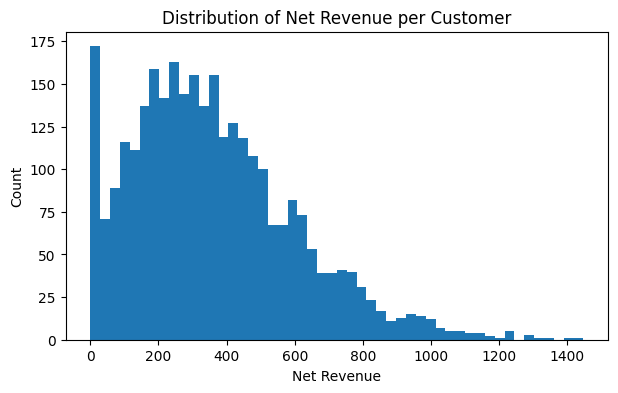

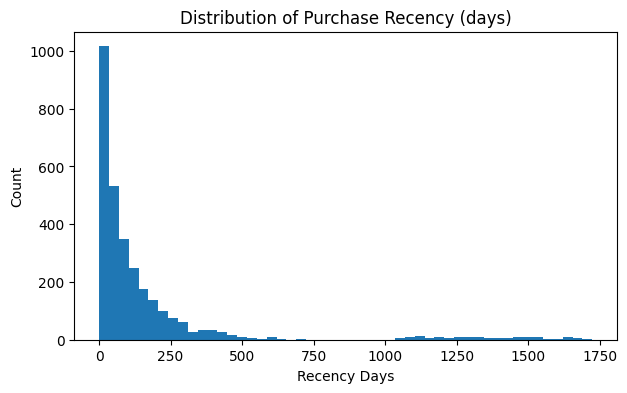

In [28]:
plt.figure(figsize=(7,4))
plt.hist(customer_features["net_revenue"], bins=50)
plt.title("Distribution of Net Revenue per Customer")
plt.xlabel("Net Revenue")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(customer_features["recency_days"], bins=50)
plt.title("Distribution of Purchase Recency (days)")
plt.xlabel("Recency Days")
plt.ylabel("Count")
plt.show()

**Step 7: Create an “At-Risk” Label (for driver analysis)**

This is a business-friendly rule-based label:

1) At-risk if no purchase in last 120 days OR low activity with past purchases

In [29]:
customer_features["at_risk"] = (
    (customer_features["recency_days"] >= 120) |
    ((customer_features["activity_recency_days"] >= 45) & (customer_features["orders"] > 0))
).astype(int)

customer_features["at_risk"].value_counts(normalize=True)

,proportion
at_risk,
0,0.534
1,0.466


**Step 8: Driver Comparison (At-risk vs Not)**

We compare average values to see what changes most.

In [30]:
def group_compare(df, col):
    g = df.groupby("at_risk")[col].mean()
    return pd.Series({"not_at_risk_mean": g.get(0, np.nan), "at_risk_mean": g.get(1, np.nan)})

driver_cols = [
    "orders","net_revenue","avg_order_value","promo_rate","return_rate",
    "sessions","events_per_session","interactions","avg_resolution_hours",
    "activity_recency_days"
]

drivers = pd.DataFrame({c: group_compare(customer_features, c) for c in driver_cols}).T
drivers["diff_at_risk_minus_not"] = drivers["at_risk_mean"] - drivers["not_at_risk_mean"]
drivers.sort_values("diff_at_risk_minus_not", ascending=False)

,not_at_risk_mean,at_risk_mean,diff_at_risk_minus_not
activity_recency_days,13.262172,68.055079,54.792906
events_per_session,6.008443,6.025121,0.016678
return_rate,0.082461,0.070589,-0.011873
promo_rate,0.352443,0.311426,-0.041016
interactions,0.939451,0.697425,-0.242026
orders,3.818352,2.534335,-1.284017
avg_resolution_hours,14.053613,11.581909,-2.471705
sessions,12.827715,9.125894,-3.701821
avg_order_value,111.685374,101.494477,-10.190897
net_revenue,426.143808,287.653155,-138.490653


**Step 9: RFM Scoring (easy-to-explain segmentation)**

RFM:

1) Recency (lower is better)

2) Frequency (more orders is better)

3) Monetary (higher spend is better)

In [31]:
rfm = customer_features[["customer_id", "recency_days", "orders", "net_revenue"]].copy()

rfm["R_score"] = pd.qcut(rfm["recency_days"].rank(method="first"), 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_score"] = pd.qcut(rfm["orders"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_score"] = pd.qcut(rfm["net_revenue"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)

rfm["RFM_score"] = rfm["R_score"] + rfm["F_score"] + rfm["M_score"]

def rfm_segment(row):
    score = row["RFM_score"]
    if score >= 13:
        return "High Value Loyal"
    elif score >= 10:
        return "Loyal / Growing"
    elif score >= 7:
        return "Mid Value"
    elif score >= 5:
        return "Low Value"
    else:
        return "Very Low / Inactive"

rfm["rfm_segment"] = rfm.apply(rfm_segment, axis=1)

customer_features = customer_features.merge(
    rfm[["customer_id","R_score","F_score","M_score","RFM_score","rfm_segment"]],
    on="customer_id", how="left"
)

customer_features["rfm_segment"].value_counts()

,count
rfm_segment,
Loyal / Growing,831
Mid Value,789
High Value Loyal,576
Low Value,411
Very Low / Inactive,393


**Step 10: KMeans Behavioral Segmentation**

We cluster customers using multiple behavioral features and pick the best k using silhouette score.

In [32]:
cluster_features = [
    "orders","net_revenue","avg_order_value","promo_rate","return_rate",
    "sessions","events_per_session","interactions","avg_resolution_hours",
    "recency_days","activity_recency_days","mobile_event_rate"
]

X = customer_features[cluster_features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_candidates = [3,4,5,6,7,8]
scores = []
models = {}

for k in k_candidates:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = km.fit_predict(X_scaled)
    s = silhouette_score(X_scaled, labels)
    scores.append((k, s))
    models[k] = (km, labels)

scores_df = pd.DataFrame(scores, columns=["k","silhouette"]).sort_values("silhouette", ascending=False)
scores_df

,k,silhouette
0,3,0.168291
1,4,0.159529
2,5,0.157399
3,6,0.157363
5,8,0.135241
4,7,0.132000


In [33]:
best_k = int(scores_df.iloc[0]["k"])
best_model, best_labels = models[best_k]

customer_features["cluster_segment"] = best_labels
print("Best k:", best_k)

segment_profile = customer_features.groupby("cluster_segment")[cluster_features + ["at_risk"]].mean().reset_index()
segment_profile

Best k: 3


,cluster_segment,orders,net_revenue,avg_order_value,promo_rate,return_rate,sessions,events_per_session,interactions,avg_resolution_hours,recency_days,activity_recency_days,mobile_event_rate,at_risk
0,0,0.019737,0.976776,0.976776,0.000000,0.00000,5.125000,5.941112,0.171053,4.124013,1341.434211,64.802632,0.552667,1.000000
1,1,2.436768,253.348255,106.732024,0.361378,0.06897,8.598361,6.025325,0.448478,7.862954,117.823185,47.726581,0.550457,0.539813
2,2,4.820175,571.889649,121.370596,0.335749,0.09911,15.651754,6.012578,1.480702,21.621598,67.367544,21.947368,0.545751,0.284211


**Step 11: Human-friendly labels for clusters**

We assign readable names based on cluster averages.

In [34]:
profile = segment_profile.set_index("cluster_segment")
cluster_names = {}

for seg in profile.index:
    r = profile.loc[seg]
    if r["net_revenue"] > profile["net_revenue"].quantile(0.75) and r["recency_days"] < profile["recency_days"].quantile(0.25):
        cluster_names[seg] = "High Value Active"
    elif r["at_risk"] > 0.6 and r["recency_days"] > profile["recency_days"].quantile(0.75):
        cluster_names[seg] = "At-Risk / Dormant"
    elif r["promo_rate"] > profile["promo_rate"].quantile(0.75):
        cluster_names[seg] = "Discount-Driven"
    elif r["interactions"] > profile["interactions"].quantile(0.75):
        cluster_names[seg] = "Support-Heavy"
    else:
        cluster_names[seg] = "Core / Average"

customer_features["cluster_label"] = customer_features["cluster_segment"].map(cluster_names)
customer_features[["cluster_segment","cluster_label"]].drop_duplicates().sort_values("cluster_segment")

,cluster_segment,cluster_label
24,0,At-Risk / Dormant
0,1,Discount-Driven
2,2,High Value Active


**Step 12: Cohort Retention (Monthly repeat purchases)**

We build a cohort matrix:

1) cohort = signup month

2) retention = who purchases again in later months

In [35]:
tx_month = fact_transactions.copy()
tx_month["month"] = tx_month["transaction_time"].dt.to_period("M").astype(str)

cust_month = tx_month.groupby(["customer_id","month"]).agg(purchased=("order_id","count")).reset_index()
cust_month = cust_month.merge(customer_features[["customer_id","cohort_month"]], on="customer_id", how="left")

def to_period_month(s):
    return pd.Period(s, freq="M")

cust_month["cohort_p"] = cust_month["cohort_month"].apply(to_period_month)
cust_month["month_p"] = cust_month["month"].apply(to_period_month)
cust_month["cohort_index"] = (cust_month["month_p"] - cust_month["cohort_p"]).apply(lambda x: x.n)

cohort_counts = cust_month.groupby(["cohort_month","cohort_index"]).agg(customers=("customer_id","nunique")).reset_index()
cohort_sizes = cohort_counts[cohort_counts["cohort_index"] == 0][["cohort_month","customers"]].rename(columns={"customers":"cohort_size"})
cohort_retention = cohort_counts.merge(cohort_sizes, on="cohort_month", how="left")
cohort_retention["retention_rate"] = cohort_retention["customers"] / cohort_retention["cohort_size"]

cohort_matrix = cohort_retention.pivot(index="cohort_month", columns="cohort_index", values="retention_rate").fillna(0)
cohort_matrix.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cohort_month,,,,,,,,,,,,,,,,,,,,,
2024-01,1.0,1.250000,1.750000,1.166667,1.250000,1.500000,1.500000,1.000000,1.833333,0.916667,...,1.833333,1.250000,1.166667,1.416667,1.000000,1.250000,1.333333,0.916667,1.166667,1.333333
2024-02,1.0,1.857143,4.142857,3.142857,2.857143,2.428571,2.142857,3.571429,1.571429,3.000000,...,1.571429,2.428571,2.571429,2.142857,1.714286,1.857143,3.285714,2.285714,3.142857,0.000000
2024-03,1.0,1.272727,3.090909,1.727273,1.363636,1.181818,1.909091,1.727273,2.363636,0.909091,...,2.454545,1.727273,1.909091,1.545455,1.181818,1.636364,2.454545,1.727273,0.000000,0.000000
2024-04,1.0,2.714286,2.142857,3.000000,2.000000,2.000000,3.000000,3.285714,2.428571,2.571429,...,3.000000,4.000000,2.857143,2.000000,3.428571,1.857143,2.714286,0.000000,0.000000,0.000000
2024-05,1.0,1.400000,1.900000,1.900000,1.400000,1.300000,1.600000,2.000000,1.900000,1.300000,...,1.900000,1.700000,1.600000,2.200000,2.300000,1.400000,0.000000,0.000000,0.000000,0.000000


**Step 13: Export CSVs for Power BI**

These are the files you load directly into Power BI.

In [36]:
exports = {
    "dim_customer.csv": dim_customer,
    "fact_transactions.csv": fact_transactions,
    "fact_interactions.csv": fact_interactions,
    "fact_events.csv": fact_events.sample(min(200000, len(fact_events)), random_state=SEED),
    "customer_features.csv": customer_features,
    "segment_profile.csv": segment_profile,
    "cohort_retention_long.csv": cohort_retention,
    "cohort_matrix.csv": cohort_matrix.reset_index()
}

for fname, df in exports.items():
    path = os.path.join(OUT_DIR, fname)
    df.to_csv(path, index=False)
    print("Saved:", path, df.shape)

Saved: /content/customer_intelligence_outputs/dim_customer.csv (3000, 6)
Saved: /content/customer_intelligence_outputs/fact_transactions.csv (9660, 14)
Saved: /content/customer_intelligence_outputs/fact_interactions.csv (2480, 12)
Saved: /content/customer_intelligence_outputs/fact_events.csv (200000, 10)
Saved: /content/customer_intelligence_outputs/customer_features.csv (3000, 39)
Saved: /content/customer_intelligence_outputs/segment_profile.csv (3, 14)
Saved: /content/customer_intelligence_outputs/cohort_retention_long.csv (299, 5)
Saved: /content/customer_intelligence_outputs/cohort_matrix.csv (23, 25)


**Step 14: Auto-generate an Insights Summary**

This creates a quick text file with:

1) at-risk rate

2) biggest behavioral differences

3) segment distribution

In [37]:
drivers = drivers.copy()
drivers_sorted = drivers.sort_values("diff_at_risk_minus_not", ascending=False)

summary_lines = []
summary_lines.append("Customer Intelligence Platform - Auto Insights Summary")
summary_lines.append(f"As of date: {AS_OF.date()}")
summary_lines.append("")
summary_lines.append("At-risk rate:")
summary_lines.append(f"- {customer_features['at_risk'].mean():.1%} of customers flagged as at-risk (recency/activity rules).")
summary_lines.append("")
summary_lines.append("Top differences (at-risk vs not-at-risk):")
for idx, row in drivers_sorted.head(6).iterrows():
    summary_lines.append(f"- {idx}: at-risk mean {row['at_risk_mean']:.2f} vs not-at-risk mean {row['not_at_risk_mean']:.2f}")

summary_lines.append("")
summary_lines.append("Segment snapshot:")
seg_counts = customer_features["cluster_label"].value_counts(normalize=True).head(5)
for seg, pct in seg_counts.items():
    summary_lines.append(f"- {seg}: {pct:.1%}")

summary_text = "\n".join(summary_lines)

summary_path = os.path.join(OUT_DIR, "INSIGHTS_SUMMARY.txt")
with open(summary_path, "w") as f:
    f.write(summary_text)

print(summary_text)
print("\nSaved:", summary_path)

Customer Intelligence Platform - Auto Insights Summary
As of date: 2025-12-31

At-risk rate:
- 46.6% of customers flagged as at-risk (recency/activity rules).

Top differences (at-risk vs not-at-risk):
- activity_recency_days: at-risk mean 68.06 vs not-at-risk mean 13.26
- events_per_session: at-risk mean 6.03 vs not-at-risk mean 6.01
- return_rate: at-risk mean 0.07 vs not-at-risk mean 0.08
- promo_rate: at-risk mean 0.31 vs not-at-risk mean 0.35
- interactions: at-risk mean 0.70 vs not-at-risk mean 0.94
- orders: at-risk mean 2.53 vs not-at-risk mean 3.82

Segment snapshot:
- Discount-Driven: 56.9%
- High Value Active: 38.0%
- At-Risk / Dormant: 5.1%

Saved: /content/customer_intelligence_outputs/INSIGHTS_SUMMARY.txt


**Step 15: Create one chart for portfolio screenshots**

A clean chart you can screenshot for your report/LinkedIn/GitHub.

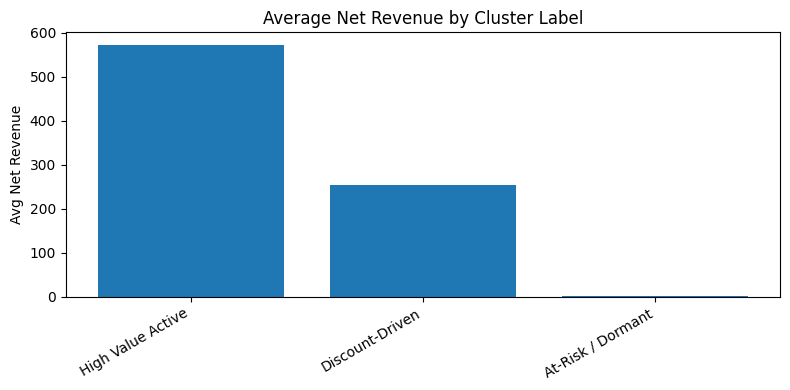

Saved chart: /content/customer_intelligence_outputs/avg_revenue_by_segment.png


In [38]:
seg_revenue = customer_features.groupby("cluster_label")["net_revenue"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
plt.bar(seg_revenue.index.astype(str), seg_revenue.values)
plt.title("Average Net Revenue by Cluster Label")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Avg Net Revenue")
plt.tight_layout()

chart_path = os.path.join(OUT_DIR, "avg_revenue_by_segment.png")
plt.savefig(chart_path, dpi=150)
plt.show()

print("Saved chart:", chart_path)

**Final: Show output files**

This lists all output artifacts created.

In [39]:
print("DONE. Files in:", OUT_DIR)
for f in sorted(os.listdir(OUT_DIR)):
    print(" -", f)

print("\nSQLite DB:", DB_PATH)

DONE. Files in: /content/customer_intelligence_outputs
 - INSIGHTS_SUMMARY.txt
 - avg_revenue_by_segment.png
 - cohort_matrix.csv
 - cohort_retention_long.csv
 - customer_features.csv
 - customer_intelligence.db
 - dim_customer.csv
 - fact_events.csv
 - fact_interactions.csv
 - fact_transactions.csv
 - segment_profile.csv

SQLite DB: /content/customer_intelligence_outputs/customer_intelligence.db
